# Getting Started Code for [Chunin Exams Food Track- CV'2021](https://www.aicrowd.com/challenges/chunin-exams-food-track-cv-2021) on AIcrowd
#### Author : Pulkit Gera

## Download Necessary Packages 📚

In [1]:
!pip install aicrowd-cli

     |████████████████████████████████| 51kB 4.5MB/s 
     |████████████████████████████████| 163kB 7.6MB/s 
     |████████████████████████████████| 61kB 5.5MB/s 
     |████████████████████████████████| 204kB 12.6MB/s 
     |████████████████████████████████| 81kB 8.8MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
     |████████████████████████████████| 71kB 8.9MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


## Download Data
The first step is to download out train test data. We will be training a model on the train data and make predictions on test data. We submit our predictions.


In [2]:
API_KEY = "fd1aed7204268f0bae2780fb808a4063" #Please enter your API Key from [https://www.aicrowd.com/participants/me]
!aicrowd login --api-key $API_KEY

API Key valid
Saved API Key successfully!


In [3]:
!aicrowd dataset download --challenge chunin-exams-food-track-cv-2021

train_images.zip: 100% 754M/754M [00:08<00:00, 90.5MB/s]
test_images.zip: 100% 33.9M/33.9M [00:00<00:00, 65.8MB/s]
train.csv: 100% 253k/253k [00:00<00:00, 3.07MB/s]
test.csv: 100% 7.27k/7.27k [00:00<00:00, 913kB/s]


In [ ]:
!unzip train_images.zip
!unzip test_images.zip

#Libraries

In [1]:
import cv2
import os
import csv
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import pandas as pd
import numpy as np

import keras
import glob
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from mlxtend.preprocessing import minmax_scaling
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical
from keras.layers import AveragePooling2D
from keras import layers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input, BatchNormalization, Multiply, Activation
from keras.optimizers import RMSprop, SGD
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras import backend as K
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
import tensorflow as tf

from PIL import Image, ImageOps

#Load data

In [2]:
def load_images_from_folder(folder):

  train_data=pd.read_csv('train.csv')
  images_names=train_data['ImageId']

  X=[]
  for img_name in images_names:
    img = Image.open('train_images/'+img_name)
    X.append(img.convert('RGB').resize((128, 128), Image.ANTIALIAS))

  return X
  
def load_labels(folder):
    with open(folder, mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        labels = []  
        line_count = 0  
        for row in csv_reader:
            if line_count == 0:
                line_count += 1
            labels.append(row['ClassName'])
            line_count += 1
        
        return labels
    

train_images = load_images_from_folder('./train.csv')
train_labels = load_labels('./train.csv')
test_images = load_images_from_folder('./test_images/')
train_images = np.array([np.array(x) for x in train_images])
train_images = train_images/255.


In [3]:
le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = train_labels_enc.reshape(len(train_labels_enc), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

train_labels_enc = le.transform(train_labels)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = train_labels_enc.reshape(len(train_labels_enc), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

train_labels = onehot_encoded 

In [4]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.15, random_state=42)
# X_train, y_train = train_images, train_labels

#For Part 2

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
pre_trained_model = InceptionV3(input_shape = (160, 160, 3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')
for layer in pre_trained_model.layers:
  layer.trainable = False

from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(pre_trained_model.output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(61, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['categorical_accuracy'])


train_datagen = ImageDataGenerator(
    rotation_range=40,      #rotation
    width_shift_range=0.2,  #translation with widht
    height_shift_range=0.2,  #translation with height
    brightness_range=[0.2,1.0] #color brighness change
    )

model.fit(X_train, y_train, epochs = 30, batch_size = 32, validation_split=0.15)
# model.fit_generator(train_datagen.flow(X_train, y_train, batch_size = 32), validation_data = (X_val,y_val), steps_per_epoch = X_train.shape[0]/32,  epochs = 25)

In [ ]:
model.save('mymodel')

INFO:tensorflow:Assets written to: mymodel/assets


In [ ]:
train_data=pd.read_csv('test.csv')
images_names=train_data['ImageId']

X=[]
for img_name in images_names:
  img = Image.open('test_images/'+img_name)
  X.append(img.convert('RGB').resize((160, 160), Image.ANTIALIAS))


X = np.array([np.array(x) for x in X])
X = X / 255.
ans = model.predict(X)

res = []
for i in range(ans.shape[0]):
  ind = np.argmax(ans[i])
  res.append(ind)
res = (le.inverse_transform(res))



In [ ]:
x= np.dstack((np.arange(0, res.size),res))[0]
np.savetxt("submission.csv",x, fmt='%s', delimiter=",",header=",ClassName")

In [ ]:
model.save('mymodel')

INFO:tensorflow:Assets written to: mymodel/assets


#For Part 1

#Baisc Model

In [ ]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(128,128,3)))
model.add(MaxPool2D())
model.add(BatchNormalization())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
# model.add(AveragePooling2D())
model.add(BatchNormalization())

# model.add(Conv2D(64, 3, padding="same", activation="relu"))
# model.add(MaxPool2D())


# model.add(Conv2D(64, 3, padding="same", activation="relu"))
# model.add(MaxPool2D())


# model.add(Conv2D(64, 3, padding="same", activation="relu"))
# model.add(MaxPool2D())
# model.add(AveragePooling2D())
# model.add(GlobalAveragePooling2D())
# model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(61, activation="softmax"))

model.summary()

model.compile(optimizer =keras.optimizers.Adam() , loss = "categorical_crossentropy", metrics=["categorical_accuracy"])

basicmodelhistory = model.fit(X_train, y_train, batch_size = 32, epochs = 25, verbose=1, validation_split=0.2)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)       

In [18]:
import pickle
with open('./basicmodelHistoryDict', 'wb') as file_pi:
    pickle.dump(basicmodelhistory.history, file_pi)

#Batch Normalization

After Batch Normalization model performs well on validation data

In [11]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(128,128,3)))
model.add(MaxPool2D())
model.add(BatchNormalization())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(61, activation="softmax"))

model.compile(optimizer =keras.optimizers.Adam() , loss = "categorical_crossentropy", metrics=["categorical_accuracy"])
batchnormhistory = model.fit(X_train, y_train, batch_size = 32, epochs = 25, verbose=0, validation_split=0.2)

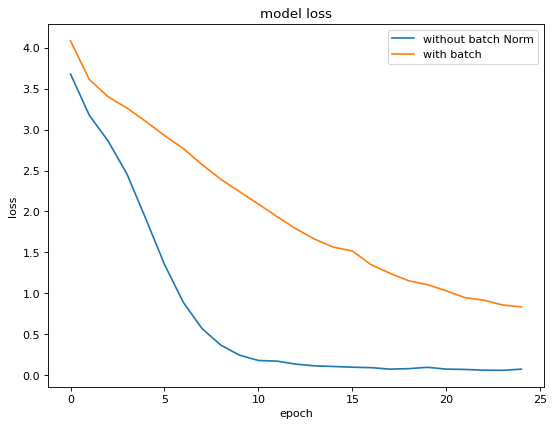

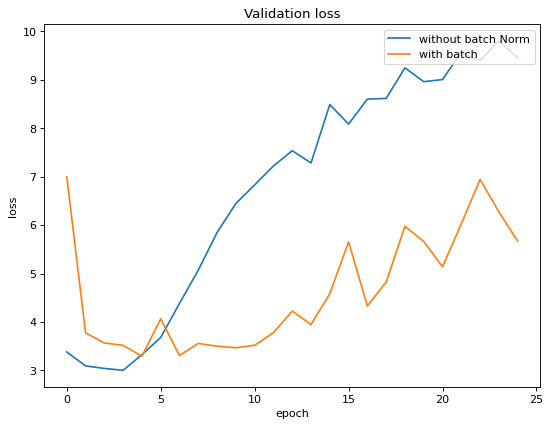

In [12]:
from matplotlib.pyplot import figure

withbatch = batchnormhistory.history['loss']
withoutbatch = basicmodelhistory.history['loss']
figure(figsize=(8, 6), dpi=80)
plt.plot(withoutbatch)
plt.plot(withbatch)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['without batch Norm','with batch'], loc='upper right')
plt.show()


withbatch = batchnormhistory.history['val_loss']
withoutbatch = basicmodelhistory.history['val_loss']
figure(figsize=(8, 6), dpi=80)
plt.plot(withoutbatch)
plt.plot(withbatch)
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['without batch Norm','with batch'], loc='upper right')
plt.show()

#Optimization Function

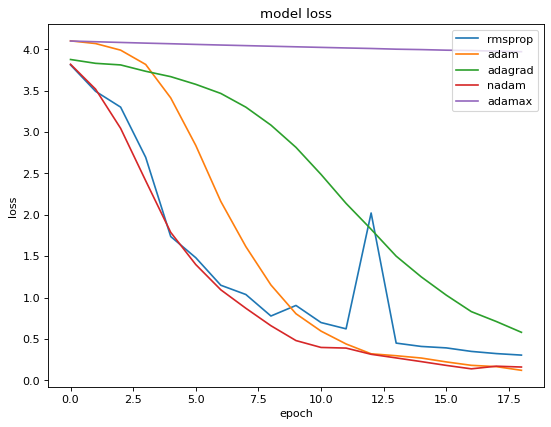

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.plot(rmsprop[1:])
plt.plot(adam[1:])
plt.plot(adagrad[1:])
plt.plot(nadam[1:])
plt.plot(adamax[1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch') 
plt.legend(['rmsprop', 'adam','adagrad','nadam','adamax'], loc='upper right')
plt.show()


#Dropout
When you increase dropout beyond a certain threshold, it results in the model not being able to fit properly. Intuitively, a higher dropout rate would result in a higher variance to some of the layers, which also degrades training.

In [14]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(128,128,3)))
model.add(MaxPool2D())
model.add(BatchNormalization())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(61, activation="softmax"))

model.compile(optimizer =keras.optimizers.Adam() , loss = "categorical_crossentropy", metrics=["categorical_accuracy"])
dropout50 = model.fit(X_train, y_train, batch_size = 32, epochs = 25, verbose=0, validation_split=0.2)

In [15]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(128,128,3)))
model.add(MaxPool2D())
model.add(BatchNormalization())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(BatchNormalization())
model.add(Dropout(0.7))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(61, activation="softmax"))

model.compile(optimizer =keras.optimizers.Adam() , loss = "categorical_crossentropy", metrics=["categorical_accuracy"])
dropout70 = model.fit(X_train, y_train, batch_size = 32, epochs = 25, verbose=0, validation_split=0.2)

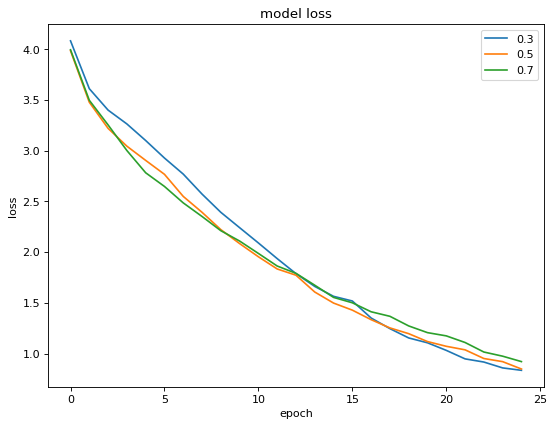

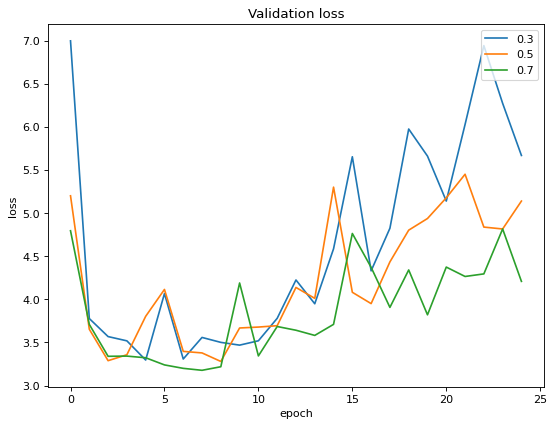

In [17]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
dropout30 = batchnormhistory.history['loss']
plt.plot(dropout30)
plt.plot(dropout50.history['loss'])
plt.plot(dropout70.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['0.3','0.5','0.7'], loc='upper right')
plt.show()


figure(figsize=(8, 6), dpi=80)
dropout30 = batchnormhistory.history['val_loss']
plt.plot(dropout30)
plt.plot(dropout50.history['val_loss'])
plt.plot(dropout70.history['val_loss'])
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['0.3','0.5','0.7'], loc='upper right')
plt.show()

#Pooling Stratergy

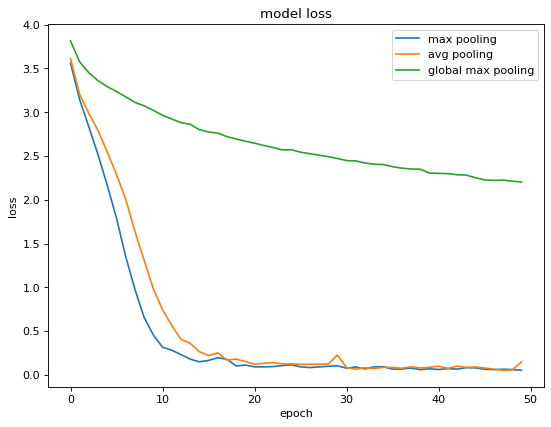

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
gblmaxpooling = history.history['loss']
plt.plot(maxpooling)
plt.plot(avgpooling)
plt.plot(gblmaxpooling)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['max pooling ','avg pooling','global max pooling','0.8'], loc='upper right')
plt.show()

#Activation Functions

In [ ]:
def model(activationfunction):
  model = Sequential()
  model.add(Conv2D(32,3,padding="same", activation=activationfunction, input_shape=(128,128,3)))
  model.add(MaxPool2D())

  model.add(Conv2D(32, 3, padding="same", activation=activationfunction))
  model.add(MaxPool2D())

  model.add(Conv2D(64, 3, padding="same", activation=activationfunction))
  model.add(MaxPool2D())
  model.add(Dropout(0.3))

  model.add(Flatten())
  # model.add(Dense(128,activation="relu"))
  model.add(Dense(61, activation="softmax"))

  model.summary()

  model.compile(optimizer =keras.optimizers.Adam() , loss = "categorical_crossentropy", metrics=["categorical_accuracy"])
  history = model.fit(X_train, y_train, batch_size = 32, epochs = 25, verbose=2, validation_split=0.2)

  return history

In [ ]:
tanhmodel = model('tanh')
relumodel = model('relu')

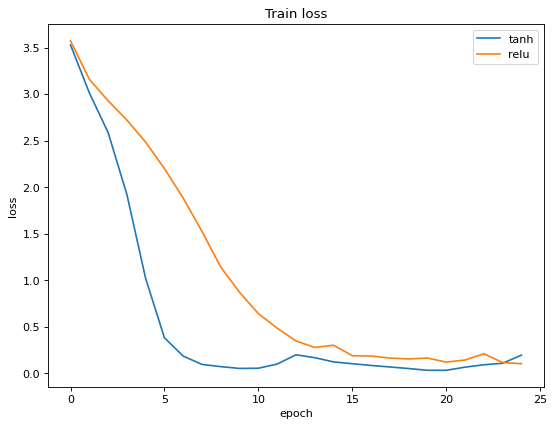

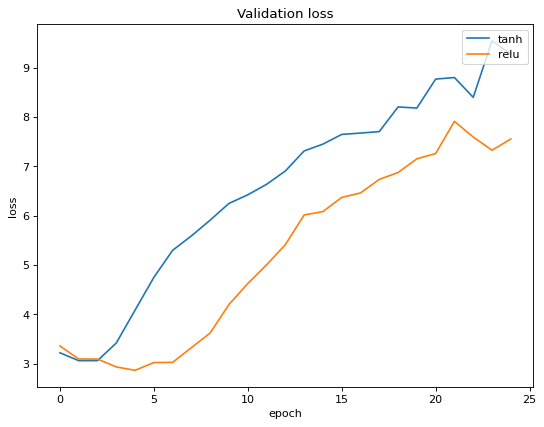

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.plot(tanhmodel.history['loss'])
plt.plot(relumodel.history['loss'])

plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['tanh','relu'], loc='upper right')
plt.show()

figure(figsize=(8, 6), dpi=80)
plt.plot(tanhmodel.history['val_loss'])
plt.plot(relumodel.history['val_loss'])
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['tanh','relu'], loc='upper right')
plt.show()

#Adding more layers

By more layers model can learn in few echos more features. Using less layers model is getting overfitted.

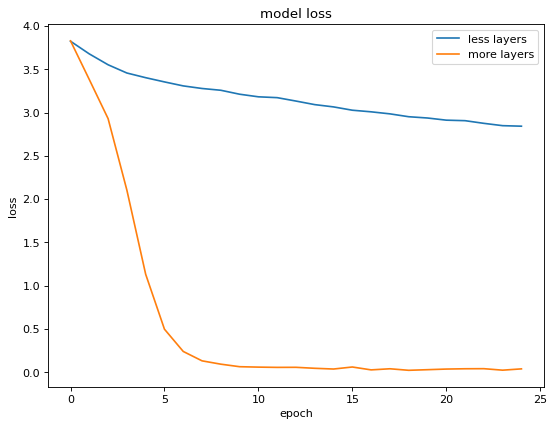

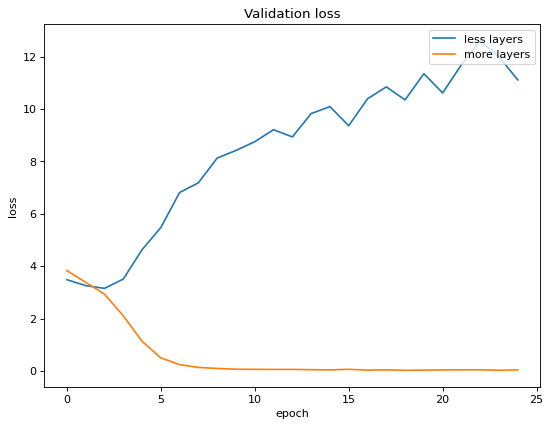

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
model2 = history.history['loss']
plt.plot(model1)
plt.plot(model2)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['less layers','more layers'], loc='upper right')
plt.show()


figure(figsize=(8, 6), dpi=80)
model1 = history.history['val_loss']
plt.plot(model1)
plt.plot(model2)
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['less layers','more layers'], loc='upper right')
plt.show()


#Basic Augmentation

In [5]:

train_datagen = ImageDataGenerator(
    rotation_range=40,      #rotation
    width_shift_range=0.2,  #translation with widht
    height_shift_range=0.2,  #translation with height
    brightness_range=[0.2,1.0] #color brighness change
    )
# train_datagen.fit(X_train,y_train)
model = Sequential()

model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(128,128,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(61, activation="softmax"))

model.summary()

model.compile(optimizer =keras.optimizers.Adam() , loss = "categorical_crossentropy", metrics=["categorical_accuracy"])
modelwithaug  = model.fit_generator(train_datagen.flow(X_train, y_train, batch_size = 32), validation_data = (X_val,y_val), steps_per_epoch = X_train.shape[0]/32,  epochs = 25)

import pickle
with open('./augmodHistoryDict', 'wb') as file_pi:
    pickle.dump(modelwithaug.history, file_pi)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               4

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
247/247 [==============================] - 69s 142ms/step - loss: 35.3862 - categorical_accuracy: 0.0594 - val_loss: 3.9697 - val_categorical_accuracy: 0.0908
Epoch 2/25
247/247 [==============================] - 32s 131ms/step - loss: 3.8348 - categorical_accuracy: 0.0978 - val_loss: 3.8952 - val_categorical_accuracy: 0.0929
Epoch 3/25
247/247 [==============================] - 33s 131ms/step - loss: 3.7826 - categorical_accuracy: 0.1023 - val_loss: 3.8116 - val_categorical_accuracy: 0.0922
Epoch 4/25
247/247 [==============================] - 33s 132ms/step - loss: 3.7659 - categorical_accuracy: 0.1009 - val_loss: 3.8091 - val_categorical_accuracy: 0.0929
Epoch 5/25
247/247 [==============================] - 32s 131ms/step - loss: 3.7732 - categorical_accuracy: 0.0968 - val_loss: 3.8017 - val_categorical_accuracy: 0.0944
Epoch 6/25
247/247 [==============================] - 33s 132ms/step - loss: 3.7549 - categorical_accuracy: 0.1030 - val_loss: 3.7959 - val_categorical_ac

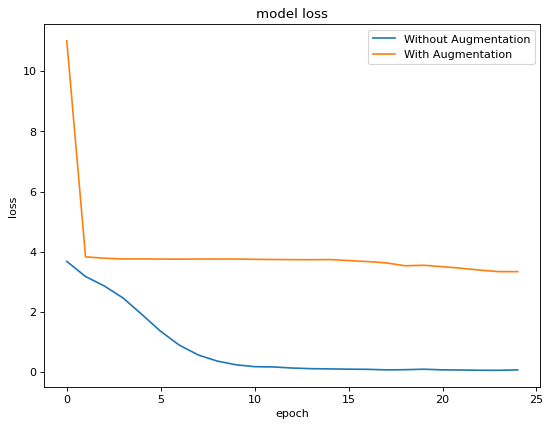

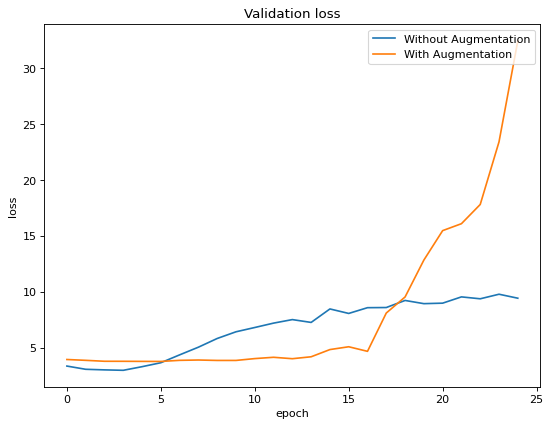

In [6]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

basicmodelhistory = pickle.load(open('/content/basicmodelHistoryDict', "rb"))
augmodHistoryDict = pickle.load(open('/content/augmodHistoryDict', "rb"))

plt.plot(basicmodelhistory['loss'])
plt.plot(augmodHistoryDict['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Without Augmentation','With Augmentation'], loc='upper right')
plt.show()


figure(figsize=(8, 6), dpi=80)
plt.plot(basicmodelhistory['val_loss'])
plt.plot(augmodHistoryDict['val_loss'])
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Without Augmentation','With Augmentation'], loc='upper right')
plt.show()
